### 1 Imports & setup

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch
np.random.seed(42) 

### 2 Environment definition
 A 4x4 gridworld environment for Q-Learning demonstration.
    
    Grid Layout:
    [0, 0, 0, G]  <- Goal at (0,3), reward +10
    [0, X, 0, 0]  <- Wall at (1,1), reward -1
    [0, 0, 0, 0]
    [S, 0, 0, 0]  <- Start at (3,0)

In [152]:
class GridWorld:
    def __init__(self):
        self.grid = np.array([
            [0, 0, 0, 1],      # Goal at (0, 3) with value 1
            [0, -1, 0, 0],     # Wall at (1, 1) with value -1
            [0, 0, 0, 0],
            [0, 0, 0, 0]
        ])
        self.start_state = (3, 0)
        self.goal_state = (0, 3)
        self.wall_state = (1, 1)
        self.state = self.start_state
        self.action_names = ['Up', 'Right', 'Down', 'Left']

# Puts the agent back at the starting position,called at the beginning of each new episode 
    def reset(self): 
        self.state = self.start_state
        return self.state

# Check if agent is in terminal state (goal or wall)
    def is_terminal(self, state): 
        return self.grid[state] == 1 or self.grid[state] == -1
    
# Get next state given current state and action
    def get_next_state(self, state, action): 
        next_state = list(state)
        if action == 0:  # Up
            next_state[0] = max(0, state[0] - 1)
        elif action == 1:  # Right
            next_state[1] = min(3, state[1] + 1)
        elif action == 2:  # Down
            next_state[0] = min(3, state[0] + 1)
        elif action == 3:  # Left
            next_state[1] = max(0, state[1] - 1)
        return tuple(next_state)

# Execute action (move agent) and return next state, reward, and if episode is over
    def step(self, action):
        next_state = self.get_next_state(self.state, action)
        if next_state == self.goal_state:
            reward = 10
        elif next_state == self.wall_state:
            reward = -1
        else:
            reward = 0
            
        self.state = next_state
        done = self.is_terminal(next_state)
        return next_state, reward, done

# Display the current grid state
    def render(self):
        grid_display = np.zeros((4, 4), dtype=str)
        grid_display[:] = '·'
        grid_display[self.goal_state] = 'G'
        grid_display[self.wall_state] = 'X'
        grid_display[self.state] = 'A'
        
        print("\n+---+---+---+---+")
        for i in range(4):
            print(f"| {' | '.join(grid_display[i])} |")
            print("+---+---+---+---+")
        print()


### 3 Agent definition
 Q-Learning agent that learns optimal policy through interaction/experience.
    
 Parameters / compontents:
- Q-table: Stores Q-values for each state-action pair
- Learning rate (α): Controls how much new information overrides old (0-1)
- Discount factor (γ): Importance of future rewards (0-1)
- Exploration rate (ε): Probability of random action for exploration (0-1)
- Epsilon decay: Gradually reduces exploration over time

Q-Learning update rule:
Q(s,a) ← Q(s,a) + α[R + γ·max Q(s',a') - Q(s,a)]


In [153]:
class QLearningAgent:
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0):
        self.q_table = np.zeros((4, 4, 4))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.min_epsilon = 0.01 
        self.decay_factor = 0.995
        self.action_names = ['Up', 'Right', 'Down', 'Left']

# Epsilon-greedy action selection with decay. With probability epsilon, choose random action (explore). Otherwise, choose action with highest Q-value (exploit).
    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.exploration_rate:
            return np.random.randint(0, 4)
        else:
            return np.argmax(self.q_table[state])

#  Update Q-value using Q-learning formula: Q(s,a) ← Q(s,a) + α[R + γ·max Q(s',a') - Q(s,a)] to make smarter choices after every move
    def update_q_value(self, state, action, reward, next_state):
        
        # Get maximum Q-value for next state (s')
        max_future_q = np.max(self.q_table[next_state])
        
        # Current Q-value Q(s,a)
        current_q = self.q_table[state][action] 
        
        # Q-learning update formula
        new_q = current_q + self.learning_rate * (
            reward + self.discount_factor * max_future_q - current_q
        )
        self.q_table[state][action] = new_q
    
# Extract policy (action indexes 0-3): "What action should I take?
    def get_policy(self):
        policy = np.zeros((4, 4), dtype=int)
        for i in range(4):
            for j in range(4):
                policy[i, j] = np.argmax(self.q_table[i, j])
        return policy

# Extract max Q-value for each grid position: "How good is this state/how much reward can I expect?" 
    def get_value_function(self):
        values = np.zeros((4, 4))
        for i in range(4):
            for j in range(4):
                values[i, j] = np.max(self.q_table[i, j])
        return values


### 4 Training function

What it does
- Runs many episodes where the agent moves until reaching the goal or a wall
- Tracks total rewards and steps for every episode
- After every move, updates the Q-table with what was learned
- Tracks TD (Temporal Difference) errors to measure learning progress
- Detects when optimal policy is found (consistent 6-step solutions)
- Detects when Q-table has converged (TD errors become very small)

 Parameters
 - env: GridWorld environment
 - agent: QLearningAgent
 - episodes: Number of training episodes
 - verbose: Print detailed step-by-step info
 - log_interval: Print progress every 100 episodes
    
 Returns
 - rewards_per_episode: Total reward collected per episode
 - steps_per_episode: Number of steps taken per episode
 - epsilons: List of epsilon values per episode
 - td_errors: List of mean TD errors per episode
 - metrics: Dictionary with training milestones (optimal_found_episode, converged_episode, total_episodes)



In [154]:
def train_agent(env, agent, episodes=1000, verbose=False, log_interval=100):
    rewards_per_episode = []
    steps_per_episode = []
    epsilons = []
    td_errors = []
    
    optimal_found_episode = None
    converged_episode = None
    optimal_steps = 6
    
    min_epsilon = agent.min_epsilon
    decay_factor = agent.decay_factor
    
    for episode in range(episodes): 
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        episode_td_errors = [] 
        
        while not done:  
            action = agent.choose_action(state)
            next_state, reward, done = env.step(action)
            
            max_future_q = np.max(agent.q_table[next_state])
            current_q = agent.q_table[state][action]
            td_error = abs(reward + agent.discount_factor * max_future_q - current_q)
            episode_td_errors.append(td_error)  
            
            agent.update_q_value(state, action, reward, next_state)
            
            total_reward += reward
            steps += 1
            state = next_state
            if steps > 100: 
                break
       
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)
        agent.exploration_rate = max(min_epsilon, agent.exploration_rate * decay_factor)
        epsilons.append(agent.exploration_rate)
        
        mean_td_error = np.mean(episode_td_errors) if episode_td_errors else 0
        td_errors.append(mean_td_error)
        
        if optimal_found_episode is None and episode >= 50:
            recent_steps = steps_per_episode[-50:]
            if np.mean(recent_steps) <= optimal_steps and np.std(recent_steps) < 0.5:
                optimal_found_episode = episode + 1
        
        if converged_episode is None and episode >= 100:
            recent_td_errors = td_errors[-100:]
            if np.mean(recent_td_errors) < 1e-3:
                converged_episode = episode + 1

        if (episode + 1) % log_interval == 0:
            avg_reward = np.mean(rewards_per_episode[-log_interval:])
            avg_steps = np.mean(steps_per_episode[-log_interval:])
            avg_td_error = np.mean(td_errors[-log_interval:])
            print(f"Episode {episode + 1}/{episodes} | Avg Reward: {avg_reward:.2f} | Avg Steps: {avg_steps:.2f} | Avg TD Error: {avg_td_error:.4f}")
    
    metrics = {
        'total_episodes': episodes,
        'optimal_found_episode': optimal_found_episode,
        'converged_episode': converged_episode
    }
    
    return rewards_per_episode, steps_per_episode, epsilons, td_errors, metrics


### 5 Basic visualization & testing functions

In [155]:
# Visualize the learned policy as arrows on the grid.
def visualize_policy(agent, env):
    policy = agent.get_policy()
    arrow_map = {0: '↑', 1: '→', 2: '↓', 3: '←'}
    print("\nLearned policy:")
    print("=" * 40)
    print("+-------+-------+-------+-------+")
    for i in range(4):
        row_str = "|"
        for j in range(4):
            if (i, j) == env.goal_state:
                row_str += "   G   |"
            elif (i, j) == env.wall_state:
                row_str += "   X   |"
            else:
                arrow = arrow_map[policy[i, j]]
                row_str += f"   {arrow}   |"
        print(row_str)
        print("+-------+-------+-------+-------+")

# Display Q-values for each state
def visualize_q_values(agent):
    print("\nState Values (Max Q-value per state):")
    print("=" * 40)
    values = agent.get_value_function()
    for i in range(4):
        row_str = ""
        for j in range(4):
            row_str += f"{values[i, j]:6.2f}  "
        print(row_str)

# Testing learned policy by running several episodes and printing the path taken, steps, and total reward
def test_learned_policy(env, agent, num_episodes=5):
    print("\nTesting learned policy:")
    print("=" * 60)
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        steps = 0
        total_reward = 0
        path = [state]
        print(f"\nTest episode {episode + 1}:")
        print(f"Start: {state}")
        while not done and steps < 20:
            action = np.argmax(agent.q_table[state])
            next_state, reward, done = env.step(action)
            path.append(next_state)
            total_reward += reward
            steps += 1
            state = next_state
        print(f"Path: {' → '.join([str(s) for s in path])}")
        print(f"Steps: {steps}, Total reward: {total_reward}")


### 6 Advanced plotting functions

In [156]:
def plot_training_analysis(rewards, steps, epsilons, td_errors, metrics, window=50):
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Q-Learning training analysis', fontsize=16, fontweight='bold', y=0.995)
    
    # --- Plot 1: Learning Curve - Rewards ---
    ax1 = plt.subplot(2, 2, 1)
    ax1.plot(rewards, alpha=0.3, color='cornflowerblue', label='Raw', linewidth=0.8)
    if len(rewards) > window:
        rewards_smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(range(window-1, len(rewards)), rewards_smoothed, 
                color='darkblue', label=f'Smoothed ({window} ep)', linewidth=2)
    ax1.axhline(y=10, color='green', linestyle='--', label='Max possible', linewidth=2)
    ax1.set_xlabel('Episode', fontsize=11)
    ax1.set_ylabel('Total Reward', fontsize=11)
    ax1.set_title('Learning Curve: Rewards', fontsize=12, fontweight='bold')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0, len(rewards))
    
    # --- Plot 2: Learning Curve - Steps ---
    ax2 = plt.subplot(2, 2, 2)
    ax2.plot(steps, alpha=0.3, color='lightcoral', label='Raw', linewidth=0.8)
    if len(steps) > window:
        steps_smoothed = np.convolve(steps, np.ones(window)/window, mode='valid')
        ax2.plot(range(window-1, len(steps)), steps_smoothed, 
                color='darkred', label=f'Smoothed ({window} ep)', linewidth=2)
    ax2.axhline(y=6, color='green', linestyle='--', label='Optimal', linewidth=2)
    ax2.set_xlabel('Episode', fontsize=11)
    ax2.set_ylabel('Steps to Goal', fontsize=11)
    ax2.set_title('Learning Curve: Steps', fontsize=12, fontweight='bold')
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0, len(steps))
    
    # --- Plot 3: Epsilon Decay ---
    ax3 = plt.subplot(2, 2, 3)
    ax3.plot(epsilons, color='purple', linewidth=2)
    ax3.fill_between(range(len(epsilons)), epsilons, alpha=0.3, color='purple')
    
    # Mark when optimal policy was found
    if metrics['optimal_found_episode']:
        ax3.axvline(x=metrics['optimal_found_episode']-1, color='gold', 
                   linestyle='--', linewidth=2, label='Optimal found')
        ax3.legend(loc='upper right')
    
    ax3.set_xlabel('Episode', fontsize=11)
    ax3.set_ylabel('Exploration Rate (ε)', fontsize=11)
    ax3.set_title('Epsilon Decay', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(0, len(epsilons))
    ax3.set_ylim(0, 1.05)
    
    # --- Plot 4: Temporal Difference Error ---
    ax4 = plt.subplot(2, 2, 4)
    
    # Add small epsilon to avoid log(0)
    td_errors_safe = [max(td, 1e-15) for td in td_errors]
    
    ax4.plot(td_errors_safe, alpha=0.3, color='orange', label='Raw', linewidth=0.8)
    if len(td_errors) > window:
        td_smoothed = np.convolve(td_errors_safe, np.ones(window)/window, mode='valid')
        ax4.plot(range(window-1, len(td_errors)), td_smoothed, 
                color='darkorange', label=f'Smoothed ({window} ep)', linewidth=2)
    
    ax4.set_xlabel('Episode', fontsize=11)
    ax4.set_ylabel('Mean TD Error', fontsize=11)
    ax4.set_title('Temporal Difference Error', fontsize=12, fontweight='bold')
    ax4.set_yscale('log')
    ax4.legend(loc='upper right')
    ax4.grid(True, alpha=0.3, which='both')
    ax4.set_xlim(0, len(td_errors))
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()

# Heatmap of state value function V*(s) = max_a Q(s,a)
def plot_state_value_function(agent, env):
    values = agent.get_value_function()
    fig, ax = plt.subplots(figsize=(8, 7))
    im = ax.imshow(values, cmap='PuRd', aspect='auto')
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('State value', rotation=270, labelpad=20, fontsize=11)
    
    # Add value annotations
    for i in range(4):
        for j in range(4):
            text = ax.text(j, i, f'{values[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=12, fontweight='bold')
    
    # Highlight special states
    # Goal state - green border
    rect_goal = plt.Rectangle((env.goal_state[1]-0.5, env.goal_state[0]-0.5), 1, 1, 
                              fill=False, edgecolor='green', linewidth=4)
    ax.add_patch(rect_goal)
    
    # Start state - black border
    rect_start = plt.Rectangle((env.start_state[1]-0.5, env.start_state[0]-0.5), 1, 1, 
                               fill=False, edgecolor='black', linewidth=4)
    ax.add_patch(rect_start)
    
    # Wall state - red border
    rect_wall = plt.Rectangle((env.wall_state[1]-0.5, env.wall_state[0]-0.5), 1, 1, 
                              fill=False, edgecolor='red', linewidth=4)
    ax.add_patch(rect_wall)
    
    # ticks and labels
    ax.set_xticks(np.arange(4))
    ax.set_yticks(np.arange(4))
    ax.set_xlabel('Column', fontsize=11)
    ax.set_ylabel('Row', fontsize=11)
    ax.set_title('State value function (V*)', fontsize=13, fontweight='bold', pad=10)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='white', edgecolor='green', linewidth=3, label='Goal'),
        Patch(facecolor='white', edgecolor='red', linewidth=3, label='Wall'),
        Patch(facecolor='white', edgecolor='black', linewidth=3, label='Start')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.15, 1))
    
    plt.tight_layout()
    plt.show()

### 7 Main execution
The “orchestrator” of the whole project, projectt run start-to-finish.
- Instantiates the environment and agent objects.
- Calls the training function to start learning.
- Runs visualization and testing functions to check results.

Episode 100/1000 | Avg Reward: 3.51 | Avg Steps: 13.78 | Avg TD Error: 0.7098
Episode 200/1000 | Avg Reward: 7.91 | Avg Steps: 10.02 | Avg TD Error: 1.0321
Episode 300/1000 | Avg Reward: 9.12 | Avg Steps: 8.05 | Avg TD Error: 0.2870
Episode 400/1000 | Avg Reward: 9.23 | Avg Steps: 7.10 | Avg TD Error: 0.1148
Episode 500/1000 | Avg Reward: 9.23 | Avg Steps: 6.35 | Avg TD Error: 0.0368
Episode 600/1000 | Avg Reward: 10.00 | Avg Steps: 6.19 | Avg TD Error: 0.0211
Episode 700/1000 | Avg Reward: 9.89 | Avg Steps: 6.20 | Avg TD Error: 0.0042
Episode 800/1000 | Avg Reward: 10.00 | Avg Steps: 6.09 | Avg TD Error: 0.0011
Episode 900/1000 | Avg Reward: 10.00 | Avg Steps: 6.05 | Avg TD Error: 0.0021
Episode 1000/1000 | Avg Reward: 10.00 | Avg Steps: 6.03 | Avg TD Error: 0.0050

TRAINING SUMMARY
  Total episodes: 1000
  Optimal policy found: Episode 905
  Q-Table converged: Episode 818
  Final epsilon: 0.0100
  Final avg reward (last 50 ep): 10.00
  Final avg steps (last 50 ep): 6.06
  Final avg T

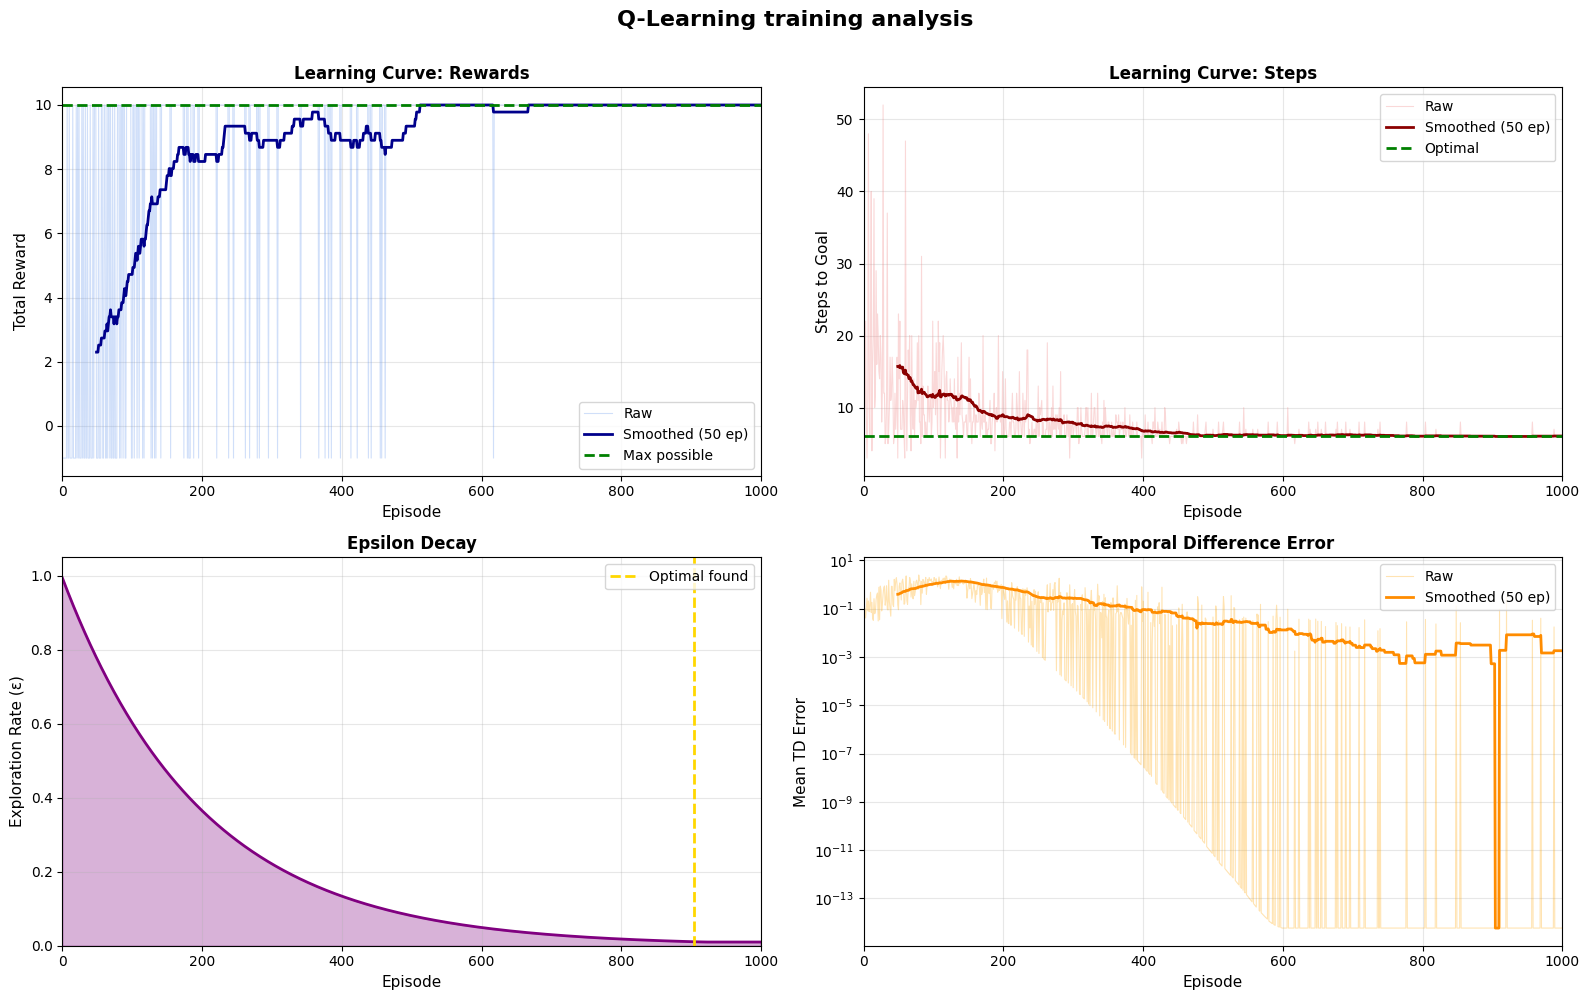

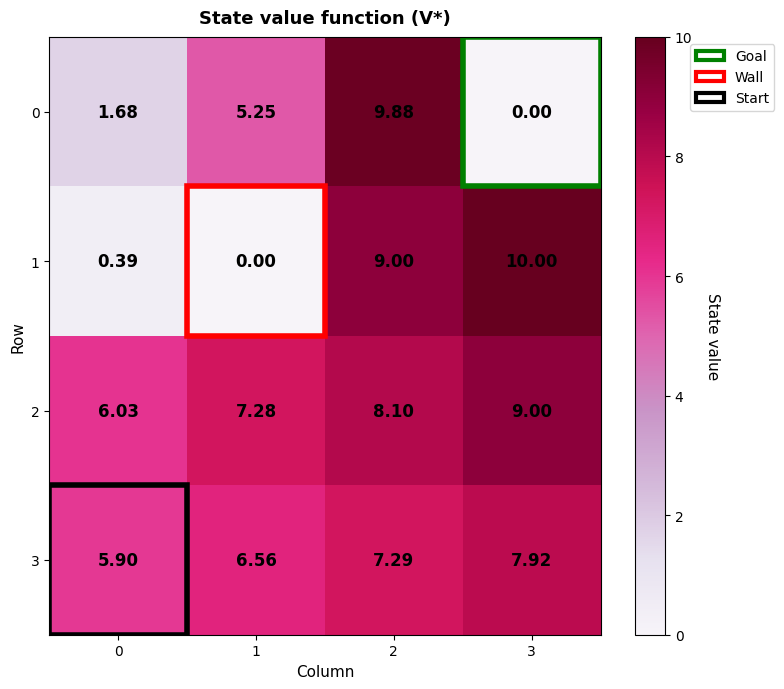

In [157]:
np.random.seed(42) 

# Create environment and agent
env = GridWorld()
agent = QLearningAgent(
    learning_rate=0.1, 
    discount_factor=0.9, 
    exploration_rate=1.0)

#Train agent
rewards, steps, epsilons, td_errors, metrics = train_agent(env, agent, episodes=1000, verbose=True, log_interval=100)

# Print training summary
print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"  Total episodes: {metrics['total_episodes']}")
if metrics['optimal_found_episode']:
    print(f"  Optimal policy found: Episode {metrics['optimal_found_episode']}")
else:
    print(f"  Optimal policy found: Not detected")
if metrics['converged_episode']:
    print(f"  Q-Table converged: Episode {metrics['converged_episode']}")
else:
    print(f"  Q-Table converged: Not detected")
print(f"  Final epsilon: {epsilons[-1]:.4f}")
print(f"  Final avg reward (last 50 ep): {np.mean(rewards[-50:]):.2f}")
print(f"  Final avg steps (last 50 ep): {np.mean(steps[-50:]):.2f}")
print(f"  Final avg TD error (last 50 ep): {np.mean(td_errors[-50:]):.6f}")
print("="*60)

# Visualize learned policy and Q-values
visualize_policy(agent, env)
visualize_q_values(agent)

# Test the learned policy
test_learned_policy(env, agent, num_episodes=5)

# Plot comprehensive training analysis
plot_training_analysis(rewards, steps, epsilons, td_errors, metrics, window=50)

# Plot state value function heatmap
plot_state_value_function(agent, env)

#### 7.1 Flatten Q Table

In [158]:
# Flatten q_table from 3D shape (4,4,4) to 2D array(16,4) in row-major order
q_flat = agent.q_table.reshape(-1, 4)

# Map state index to (row, col)
rows = [i // 4 for i in range(16)]
cols = [i % 4 for i in range(16)]

action_names = ['Up', 'Right', 'Down', 'Left']
best_actions = [action_names[int(np.argmax(q_flat[i]))] for i in range(16)]
max_q_values = [round(np.max(q_flat[i]), 2) for i in range(16)]


df = pd.DataFrame({
    'StateIndex': range(16),
    'Row': rows,
    'Col': cols,
    'Q_Up': q_flat[:, 0].round(2),     
    'Q_Right': q_flat[:, 1].round(2),
    'Q_Down': q_flat[:, 2].round(2),
    'Q_Left': q_flat[:, 3].round(2),
    'MaxQ': max_q_values,    
    'BestAction': best_actions
})

print("\n" + "="*60)
print("Full Q-table (all states)")
print("="*60)
display(df)


Full Q-table (all states)


,StateIndex,Row,Col,Q_Up,Q_Right,Q_Down,Q_Left,MaxQ,BestAction
0,0,0,0,0.08,1.68,0.02,0.10,1.68,Right
1,1,0,1,0.63,5.25,-0.69,0.19,5.25,Right
2,2,0,2,4.84,9.88,3.20,1.97,9.88,Right
3,3,0,3,0.00,0.00,0.00,0.00,0.00,Up
4,4,1,0,0.39,-0.69,0.36,0.02,0.39,Up
5,5,1,1,0.00,0.00,0.00,0.00,0.00,Up
6,6,1,2,8.49,9.00,7.05,-0.99,9.00,Right
7,7,1,3,10.00,8.85,7.88,7.99,10.00,Up
8,8,2,0,0.10,6.03,0.77,1.31,6.03,Right
9,9,2,1,-0.97,7.28,3.57,2.01,7.28,Right


### 8 Q-learning VS SARSA

#### 8.1 SARSA Agent Defintion

In [ ]:
# SARSA IMPLEMENTATION (On-Policy learning)
class SARSAAgent(QLearningAgent):    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def update_q_value_sarsa(self, state, action, reward, next_state, next_action):
        """Update Q-value using SARSA formula."""
        next_q = self.q_table[next_state][next_action]
        current_q = self.q_table[state][action]
        td_error = reward + self.discount_factor * next_q - current_q
        new_q = current_q + self.learning_rate * td_error
        self.q_table[state][action] = new_q
        return abs(td_error)

#### 8.2. SARSA training function definiton 

In [ ]:
def train_sarsa_agent(env, agent, episodes=1000, verbose=False, log_interval=100):
    """Train SARSA agent (on-policy)."""
    rewards_per_episode = []
    steps_per_episode = []
    epsilons = []
    td_errors = []
    
    optimal_found_episode = None
    converged_episode = None
    optimal_steps = 6
    
    min_epsilon = agent.min_epsilon
    decay_factor = agent.decay_factor
    
    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        episode_td_errors = []
        
        action = agent.choose_action(state)
        
        while not done:
            next_state, reward, done = env.step(action)
            next_action = agent.choose_action(next_state)
            
            td_error = agent.update_q_value_sarsa(state, action, reward, next_state, next_action)
            episode_td_errors.append(td_error)
            
            total_reward += reward
            steps += 1
            state = next_state
            action = next_action
            
            if steps > 100:
                break
        
        rewards_per_episode.append(total_reward)
        steps_per_episode.append(steps)
        agent.exploration_rate = max(min_epsilon, agent.exploration_rate * decay_factor)
        epsilons.append(agent.exploration_rate)
        
        mean_td_error = np.mean(episode_td_errors) if episode_td_errors else 0
        td_errors.append(mean_td_error)
        
        if optimal_found_episode is None and episode >= 50:
            recent_steps = steps_per_episode[-50:]
            if np.mean(recent_steps) <= optimal_steps and np.std(recent_steps) < 0.5:
                optimal_found_episode = episode + 1
        
        if converged_episode is None and episode >= 100:
            recent_td_errors = td_errors[-100:]
            if np.mean(recent_td_errors) < 1e-3:
                converged_episode = episode + 1
        
        if (episode + 1) % log_interval == 0:
            avg_reward = np.mean(rewards_per_episode[-log_interval:])
            avg_steps = np.mean(steps_per_episode[-log_interval:])
            avg_td_error = np.mean(td_errors[-log_interval:])
            print(f"Episode {episode + 1}/{episodes} | Avg Reward: {avg_reward:.2f} | Avg Steps: {avg_steps:.2f} | Avg TD Error: {avg_td_error:.4f}")
    
    metrics = {
        'total_episodes': episodes,
        'optimal_found_episode': optimal_found_episode,
        'converged_episode': converged_episode,
        'rewards': rewards_per_episode,
        'steps': steps_per_episode,
        'epsilons': epsilons,
        'td_errors': td_errors
    }
    
    return rewards_per_episode, steps_per_episode, epsilons, td_errors, metrics

#### 8.3 Comparison: Q-learning VS SARSA

In [166]:
def compare_algorithms(q_metrics, sarsa_metrics):
    """Compare Q-Learning and SARSA performance."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    ax = axes[0]
    window = 20
    
    q_rewards = q_metrics['rewards']
    if len(q_rewards) >= window:
        q_smoothed = np.convolve(q_rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(q_rewards)), q_smoothed, 
                color='blue', linewidth=2, label='Q-Learning')
    
    s_rewards = sarsa_metrics['rewards']
    if len(s_rewards) >= window:
        s_smoothed = np.convolve(s_rewards, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(s_rewards)), s_smoothed, 
                color='red', linewidth=2, label='SARSA')
    
    ax.axhline(y=10, color='green', linestyle='--', alpha=0.5, label='Maximum')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Average Reward')
    ax.set_title('Q-Learning vs SARSA: Rewards', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    ax = axes[1]
    
    q_steps = q_metrics['steps']
    if len(q_steps) >= window:
        q_steps_smoothed = np.convolve(q_steps, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(q_steps)), q_steps_smoothed, 
                color='blue', linewidth=2, label='Q-Learning')
    
    s_steps = sarsa_metrics['steps']
    if len(s_steps) >= window:
        s_steps_smoothed = np.convolve(s_steps, np.ones(window)/window, mode='valid')
        ax.plot(range(window-1, len(s_steps)), s_steps_smoothed, 
                color='red', linewidth=2, label='SARSA')
    
    ax.axhline(y=6, color='green', linestyle='--', alpha=0.5, label='Optimal')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Steps to Goal')
    ax.set_title('Q-Learning vs SARSA: Steps', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('Algorithm Comparison: Q-Learning (Off-Policy) vs SARSA (On-Policy)', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*60)
    print("         ALGORITHM COMPARISON SUMMARY")
    print("="*60)
    
    print("\n Convergence speed:")
    if q_metrics['optimal_found_episode']:
        print(f"  Q-Learning: Episode {q_metrics['optimal_found_episode']}")
    else:
        print(f"  Q-Learning: Not detected")
    if sarsa_metrics['optimal_found_episode']:
        print(f"  SARSA: Episode {sarsa_metrics['optimal_found_episode']}")
    else:
        print(f"  SARSA: Not detected")
    
    print("\n Final Performance (last 50 episodes):")
    print(f"  Q-Learning:")
    print(f"    Reward: {np.mean(q_rewards[-50:]):.2f} ± {np.std(q_rewards[-50:]):.2f}")
    print(f"    Steps: {np.mean(q_steps[-50:]):.2f} ± {np.std(q_steps[-50:]):.2f}")
    print(f"  SARSA:")
    print(f"    Reward: {np.mean(s_rewards[-50:]):.2f} ± {np.std(s_rewards[-50:]):.2f}")
    print(f"    Steps: {np.mean(s_steps[-50:]):.2f} ± {np.std(s_steps[-50:]):.2f}")
    print("="*60)

#### 8.4 SARSA Main Execution
Training SARSA and comparing it with Q-learning from above

Training of SARSA process
Episode 100/1000 | Avg Reward: 4.17 | Avg Steps: 17.80 | Avg TD Error: 0.4321
Episode 200/1000 | Avg Reward: 9.23 | Avg Steps: 10.84 | Avg TD Error: 1.2664
Episode 300/1000 | Avg Reward: 9.45 | Avg Steps: 8.21 | Avg TD Error: 1.1759
Episode 400/1000 | Avg Reward: 9.89 | Avg Steps: 7.17 | Avg TD Error: 0.7645
Episode 500/1000 | Avg Reward: 10.00 | Avg Steps: 6.82 | Avg TD Error: 0.5711
Episode 600/1000 | Avg Reward: 10.00 | Avg Steps: 6.43 | Avg TD Error: 0.3062
Episode 700/1000 | Avg Reward: 10.00 | Avg Steps: 6.30 | Avg TD Error: 0.2227
Episode 800/1000 | Avg Reward: 10.00 | Avg Steps: 6.18 | Avg TD Error: 0.1532
Episode 900/1000 | Avg Reward: 10.00 | Avg Steps: 6.13 | Avg TD Error: 0.1024
Episode 1000/1000 | Avg Reward: 10.00 | Avg Steps: 6.04 | Avg TD Error: 0.0325

SARSA TRAINING SUMMARY
  Total Episodes: 1000
  Optimal Policy Found: Episode 941
  Final Epsilon: 0.0100
  Final Avg Reward (last 50 ep): 10.00
  Final Avg Steps (last 50 ep): 6.06


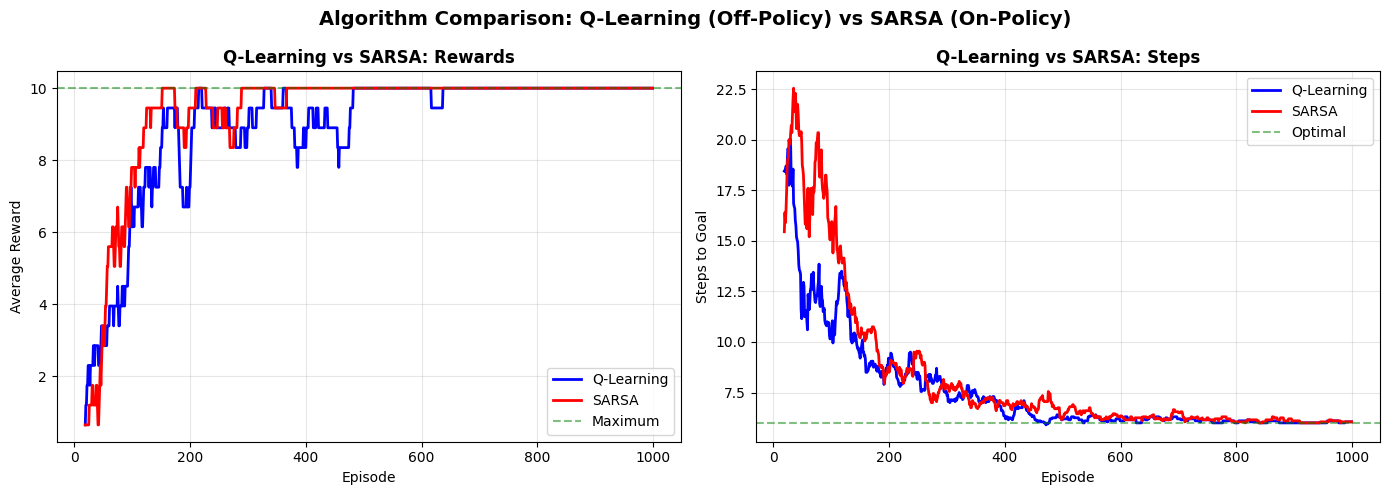


         ALGORITHM COMPARISON SUMMARY

 Convergence speed:
  Q-Learning: Episode 905
  SARSA: Episode 941

 Final Performance (last 50 episodes):
  Q-Learning:
    Reward: 10.00 ± 0.00
    Steps: 6.06 ± 0.31
  SARSA:
    Reward: 10.00 ± 0.00
    Steps: 6.06 ± 0.31

Learned policy:
+-------+-------+-------+-------+
|   →   |   →   |   →   |   G   |
+-------+-------+-------+-------+
|   ↑   |   X   |   ↑   |   ↑   |
+-------+-------+-------+-------+
|   ↓   |   →   |   →   |   ↑   |
+-------+-------+-------+-------+
|   →   |   →   |   →   |   ↑   |
+-------+-------+-------+-------+


In [172]:
print("Training of SARSA process")

# Create SARSA agent
env_sarsa = GridWorld()
sarsa_agent = SARSAAgent(learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0)

# Train SARSA
sarsa_rewards, sarsa_steps, sarsa_epsilons, sarsa_td_errors, sarsa_metrics = train_sarsa_agent(
    env_sarsa, sarsa_agent, episodes=1000, verbose=True, log_interval=100
)

print("\n" + "="*60)
print("SARSA TRAINING SUMMARY")
print("="*60)
print(f"  Total Episodes: {sarsa_metrics['total_episodes']}")
if sarsa_metrics['optimal_found_episode']:
    print(f"  Optimal Policy Found: Episode {sarsa_metrics['optimal_found_episode']}")
else:
    print(f"  Optimal Policy Found: Not detected")
print(f"  Final Epsilon: {sarsa_epsilons[-1]:.4f}")
print(f"  Final Avg Reward (last 50 ep): {np.mean(sarsa_rewards[-50:]):.2f}")
print(f"  Final Avg Steps (last 50 ep): {np.mean(sarsa_steps[-50:]):.2f}")
print("="*60)

# Get the Q-learning metrics from aboce for comparison
q_metrics = {
    'rewards': rewards,
    'steps': steps,
    'epsilons': epsilons,
    'td_errors': td_errors,
    'optimal_found_episode': metrics['optimal_found_episode'],
    'converged_episode': metrics['converged_episode']
}

# Compare both algorithms
compare_algorithms(q_metrics, sarsa_metrics)

# Show SARSA learned policy
visualize_policy(sarsa_agent, env_sarsa)